### Strategy 2: Double DQN with Randomized Training

This strategy trains a Double DQN agent on random pole lengths each episode.

### Setup and Imports

In [1]:
import os
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs("weights", exist_ok=True)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Q-Network

In [5]:
# standard Q-network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### DQNAgent Class

This class defines the full Double DQN agent, including the policy and target networks, replay memory, epsilon-greedy exploration, optimization logic, and periodic target updates. It stabilizes training by separating action selection (policy net) from action evaluation (target net).

In [6]:
from collections import deque

class DQNAgent:
    def __init__(
        self,
        state_dim, action_dim,
        lr=3e-4, gamma=0.99,
        buffer_size=100_000, batch_size=64,
        eps_start=1.0, eps_end=0.05, eps_decay=0.995,
        target_update_steps=1_000
    ):
        self.state_dim, self.action_dim = state_dim, action_dim

        self.policy_net = QNetwork(state_dim, action_dim)
        self.target_net = QNetwork(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon      = eps_start
        self.epsilon_min  = eps_end
        self.epsilon_decay= eps_decay

        self.target_update_steps = target_update_steps
        self.global_step = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            s = torch.as_tensor(state, dtype=torch.float32).unsqueeze(0)
            q = self.policy_net(s)
            return int(q.argmax(1).item())

    def store(self, s, a, r, s_next, done):
        self.memory.append((s, a, r, s_next, float(done)))

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states      = torch.as_tensor(np.array(states), dtype=torch.float32)
        actions     = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards     = torch.as_tensor(rewards, dtype=torch.float32)
        next_states = torch.as_tensor(np.array(next_states), dtype=torch.float32)
        dones       = torch.as_tensor(dones, dtype=torch.float32)

        q_sa = self.policy_net(states).gather(1, actions).squeeze(1)

        # Double DQN target
        with torch.no_grad():
            next_acts = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q    = self.target_net(next_states).gather(1, next_acts).squeeze(1)
            target    = rewards + self.gamma * (1.0 - dones) * next_q

        loss = nn.SmoothL1Loss()(q_sa, target)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        # update target
        self.global_step += 1
        if self.global_step % self.target_update_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

### Training Episode-Based Double DQN with Randomized Pole Lengths

In [7]:
def train_ddqn_episodes(
    episodes=600, max_steps_per_ep=500,
    eps_length_range=(0.4, 1.8),
    save_path="weights/s2_ddqn_episode_based.pth"
):
    env = gym.make("CartPole-v1")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)

    returns = []
    for ep in range(episodes):
        env.unwrapped.length = float(np.random.uniform(*eps_length_range))
        state, _ = env.reset()
        total_r = 0.0

        for t in range(max_steps_per_ep):
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store(state, action, reward, next_state, done)
            agent.optimize()

            state = next_state
            total_r += reward
            if done:
                break

        agent.decay_epsilon()
        returns.append(total_r)

        if (ep + 1) % 20 == 0:
            avg100 = np.mean(returns[-100:])
            print(f"Ep {ep+1}/{episodes} | return={int(total_r)} | avg100={avg100:.1f} | eps={agent.epsilon:.3f}")

    torch.save(agent.policy_net.state_dict(), save_path)
    print("Training done. Saved to:", save_path)
    return agent, returns

# Example run:
agent2, returns2 = train_ddqn_episodes()

Ep 20/600 | return=33 | avg100=38.5 | eps=0.905
Ep 40/600 | return=47 | avg100=36.0 | eps=0.818
Ep 60/600 | return=13 | avg100=34.2 | eps=0.740
Ep 80/600 | return=14 | avg100=36.2 | eps=0.670
Ep 100/600 | return=45 | avg100=36.1 | eps=0.606
Ep 120/600 | return=27 | avg100=38.8 | eps=0.548
Ep 140/600 | return=42 | avg100=52.6 | eps=0.496
Ep 160/600 | return=53 | avg100=64.2 | eps=0.448
Ep 180/600 | return=132 | avg100=82.4 | eps=0.406
Ep 200/600 | return=186 | avg100=111.3 | eps=0.367
Ep 220/600 | return=88 | avg100=149.7 | eps=0.332
Ep 240/600 | return=117 | avg100=169.3 | eps=0.300
Ep 260/600 | return=171 | avg100=189.0 | eps=0.272
Ep 280/600 | return=245 | avg100=207.3 | eps=0.246
Ep 300/600 | return=109 | avg100=205.9 | eps=0.222
Ep 320/600 | return=122 | avg100=184.7 | eps=0.201
Ep 340/600 | return=123 | avg100=169.2 | eps=0.182
Ep 360/600 | return=120 | avg100=157.4 | eps=0.165
Ep 380/600 | return=120 | avg100=144.6 | eps=0.149
Ep 400/600 | return=39 | avg100=143.9 | eps=0.135
Ep 

### Testing & Plotting

0.4
0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


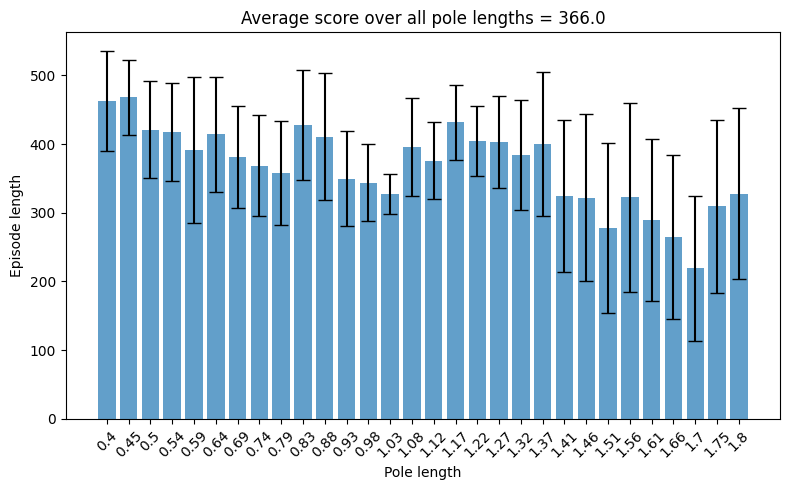

Saved: bar_plot.png and experiment_results.csv


In [8]:
# testing and plotting

# same architecture as training
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def bar_plot(results):
    data = results[0]
    avgs = {k: v for k, v in data.items() if k.startswith('Avg_')}
    stds = {k.replace('Avg', 'Std'): data[k.replace('Avg', 'Std')] for k in avgs.keys()}
    sorted_keys = sorted(avgs.keys(), key=lambda x: float(x.split('_')[1]))
    avg_values = [avgs[k] for k in sorted_keys]
    std_values = [stds[k.replace('Avg', 'Std')] for k in sorted_keys]
    overall_avg = float(np.mean(np.array(avg_values)))

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(avg_values)), avg_values, yerr=std_values, capsize=5, alpha=0.7)
    plt.xticks(range(len(avg_values)), [k.split('_')[1] for k in sorted_keys], rotation=45)
    plt.xlabel('Pole length')
    plt.ylabel('Episode length')
    plt.title(f'Average score over all pole lengths = {round(overall_avg, 0)}')
    plt.tight_layout()
    plt.savefig("bar_plot.png")
    plt.show()

# official test loop per length (don’t change this logic)
def test_pole_length(env, q_network):
    wind = 25
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    done = False
    total_reward = 0
    while not done:
        action = q_network(state).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = bool(terminated) or bool(truncated)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward
        if 500 <= total_reward <= 1000:
            if total_reward % wind == 0:
                env.unwrapped.force_mag = 75
        if total_reward > 1000:
            env.unwrapped.force_mag = 25 + (0.01 * total_reward)
    return total_reward

def test_script():
    pole_lengths = np.linspace(0.4, 1.8, 30)
    all_results = []

    # name of the trained neural network!
    trained_nn = "s2_ddqn_episode_based.pth"

    results = {}
    total_score = 0.0

    for length in pole_lengths:
        print(length)
        pole_scores = []
        for _ in range(10):
            env = gym.make('CartPole-v1')
            env.unwrapped.length = float(length)

            state_dim = env.observation_space.shape[0]
            action_dim = env.action_space.n
            model = QNetwork(state_dim, action_dim)

            # robust load across torch versions
            try:
                sd = torch.load(os.path.join("weights", trained_nn), map_location="cpu", weights_only=True)
            except TypeError:
                sd = torch.load(os.path.join("weights", trained_nn), map_location="cpu")
            model.load_state_dict(sd)
            model.eval()

            score = test_pole_length(env, model)
            pole_scores.append(score)

        mean_score = float(np.mean(pole_scores))
        std_score  = float(np.std(pole_scores))
        total_score += mean_score
        results[f"Avg_{round(length, 2)}"] = mean_score
        results[f"Std_{round(length, 2)}"] = std_score

    results["Total"] = total_score
    all_results.append(results)

    bar_plot(all_results)

    # saved it in CSV instead of excel
    pd.DataFrame(all_results).to_csv("experiment_results.csv", index=False)
    print("Saved: bar_plot.png and experiment_results.csv")

# run the test
test_script()